In [1]:
import numpy as np
import pandas as pd
from scipy import stats as st
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

In [2]:
def generate_pweights(input_events_path, breaching_locations_path, 
                      info_breach_path, N, distrs, skipfooter=0, indexes_to_keep=None):

    events = pd.read_excel(input_events_path, index_col=0, usecols=range(N+1))

    info_breach = pd.read_excel(info_breach_path, index_col=0)
    crest_heights = info_breach['crest_h']
    raising = info_breach['raising']

    events_ = pd.concat([events, crest_heights, raising], axis=1)

    pdfs = []
    pdf_eval_u = events_.T.apply(lambda row: st.uniform.pdf(row, loc=row.crest_h-2., 
                                                            scale=2.+row.raising), axis=0).iloc[:-2,:]
    pdf_eval_u.index = range(len(pdf_eval_u.index))
    pdf_eval_u = pdf_eval_u.loc[indexes_to_keep]
    
    pdf_eval_u['jp'] = pdf_eval_u.product(1) # joint probability
    pdfs.append(pdf_eval_u)

    for i in distrs.keys():
        pdf_eval = pdf_eval_u.copy()
        for stretch in [1,3,4,5,6,15,25]:
            pdf_eval[stretch] = distrs[i](events_.loc[stretch][['crest_h',
                                                                'raising']].sum()).pdf(
                                                    events_.iloc[stretch,indexes_to_keep])
     
        pdfs.append(pdf_eval)

    return pdfs

def plot_distr(c, r, ranking, ax, distrs, x_height, xhs, lw):
    argspos = np.where(ranking == c+1.)
    argspos_ = [argspos[0][i] for i in np.unique(argspos[1], return_index=True)[1]]
    vals, idxes = np.unique(argspos_, return_index=True)

    idxes_ = np.unique(idxes).tolist()
    vals = [vals[idxes.tolist().index(i)] for i in idxes_]
    
    for idx in range(0,14):
        ax[r,c].plot(xhs, distrs[idx+1](x_height).cdf(xhs), color='k', alpha=0.5)

    for idx in idxes_:
            ax[r,c].plot(xhs, distrs[idx+1](x_height).cdf(xhs), lw=lw, color='k')
    for idx in idxes_[:-1]:
            idxidx = idxes_.index(idx)
            ax[r,c].fill_between(xhs,
                             distrs[idx+1](x_height).cdf(xhs),
                             distrs[idxes_[idxidx+1]+1](x_height).cdf(xhs),
                             color=colors[vals[idxidx]])      
    
    argmax = np.argmax(idxes_)
    ax[r,c].fill_between(xhs,
                        distrs[idxes_[argmax]+1](x_height).cdf(xhs),
                        distrs[14](x_height).cdf(xhs),
                        color=colors[vals[argmax]])
    
    ax[r,c].plot(xhs, distrs[14](x_height).cdf(xhs), lw=lw, color='k')

def prob_exc(values, weights, threshold=None):
    prob = values.copy()
    N = len(values)

    if threshold:
        prob = np.array(np.sum(weights[values > threshold])/N)
    else:
        for v in np.unique(values):
            prob[values == v] = (np.sum(weights[values > v])/N)# / norm
            prob = np.array(prob)
    return prob

def dist(h):
    return lambda d_height: st.norm(loc=d_height-h, scale=0.3)

# Alternative Distributions / Beliefs

In [3]:
low_point=2 # the low point is two meters below the initial crest height
c = 25. # crest_height (example)

hh = 0.7 # example heightening (example)
ch_ = c+hh

In [4]:
pos = np.array([c-low_point, c, ch_])
labels_ = ['lowest point of\nbreach triggering\n(-2 m)', 'height\nof levee crest']

In [5]:
x = st.uniform.rvs(loc=c-low_point, scale=low_point, size=5000)
h_range = np.arange(0.6, 1.3, 0.05)

In [6]:
cdfs = [
        st.uniform.cdf(x, loc=c-low_point, scale=low_point),
        st.norm.cdf(x, loc=c-0.6, scale=0.3),    
        st.norm.cdf(x, loc=c-0.8, scale=0.3),
        st.norm.cdf(x, loc=c-1.05, scale=0.3),    
        st.norm.cdf(x, loc=c-1.3, scale=0.3),
       ]

In [7]:
distrs = {}
for i in range(len(h_range)):
    distrs.update({i+1: dist(h_range[i])})

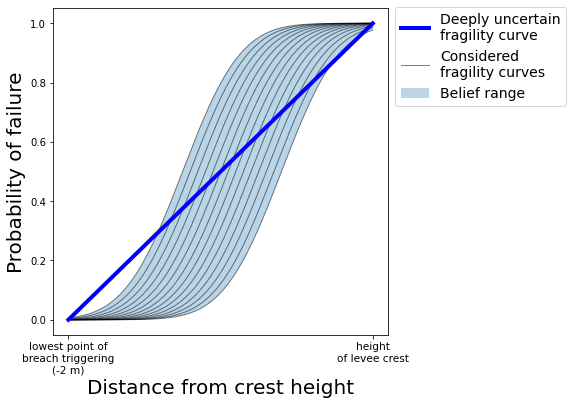

In [8]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

width=4

ax.fill_between(np.unique(x), distrs[14](c).cdf(np.unique(x)), 
                distrs[1](c).cdf(np.unique(x)), alpha=0.3, 
                label='Belief range')
ax.plot(np.unique(x), np.unique(cdfs[0]), color='blue', linewidth=width, linestyle='-', 
        label='Deeply uncertain\nfragility curve', zorder=10)

for i in range(2,14):
    ax.plot(np.unique(x), distrs[i](c).cdf(np.unique(x)), color='k', linewidth=1, linestyle='-', alpha=0.5)

ax.plot(np.unique(x), distrs[1](c).cdf(np.unique(x)), color='k', linewidth=1, linestyle='-', alpha=0.5)
ax.plot(np.unique(x), distrs[14](c).cdf(np.unique(x)), color='k', linewidth=1, linestyle='-', alpha=0.5, 
        label = 'Considered\nfragility curves')

ax.set_xticks(pos[:-1])
ax.set_xticklabels(labels_, fontsize = 10.5)

ax.set_ylabel('Probability of failure', fontsize=20)
ax.set_xlabel('Distance from crest height', fontsize=20)

plt.legend(loc='upper left', fontsize=14, bbox_to_anchor = (1,1.027))

## Calcualte Robustness under different beliefs

In [9]:
dam_unexp_du = pd.read_excel('./damage_results/damages_2m_du.xlsx', index_col = 0)
dam_unexp_unb = pd.read_excel('./damage_results/damages_2m_unbreach_du.xlsx', index_col = 0)
dam_unexp_rs2 = pd.read_excel('./damage_results/damages_2m_raise_du.xlsx', index_col = 0)

dam_unexp_du['case'] = 'un_statusquo'
dam_unexp_unb['case'] = 'un_unbreach'
dam_unexp_rs2['case'] = 'un_raise2'

In [10]:
dam_unexp_du['tot_damage'] = dam_unexp_du.loc[:, :'secc_panaB'].sum(axis=1)
dam_unexp_unb['tot_damage'] = dam_unexp_unb.loc[:, :'secc_panaB'].sum(axis=1)
dam_unexp_rs2['tot_damage'] = dam_unexp_rs2.loc[:, :'secc_panaB'].sum(axis=1)

In [11]:
dam = pd.concat([                
                 dam_unexp_du, 
                 dam_unexp_unb, 
                 dam_unexp_rs2,
                ])

In [12]:
dam['measure'] = dam.apply(lambda row: row.case.split('_')[1], axis=1)
dam['sow'] = dam.apply(lambda row: row.case.split('_')[0], axis=1)

In [13]:
dam.head()

,Pana_poA,adig_poA,adig_poB,adig_poC,adig_poD,adig_poE,adig_poF,adig_poG,cros_seccB,cros_seccC,...,ogli_mincC,pana_poB,pana_poC,pana_poD,secc_panaA,secc_panaB,case,tot_damage,measure,sow
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.053552e+09,3.303383e+07,...,1.623002e+07,0.0,0.0,0.0,0.000000e+00,0.0,un_statusquo,1.279281e+09,statusquo,un
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.761974e+08,5.759643e+07,...,0.000000e+00,0.0,0.0,0.0,9.403607e+06,0.0,un_statusquo,2.972359e+08,statusquo,un
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.704093e+08,0.000000e+00,...,7.325338e+06,0.0,0.0,0.0,1.919750e+08,0.0,un_statusquo,1.094701e+09,statusquo,un
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.775997e+09,7.049876e+08,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,un_statusquo,2.480985e+09,statusquo,un
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.882372e+08,1.503762e+08,...,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,un_statusquo,1.240088e+09,statusquo,un


In [14]:
where_nans = np.where(dam.loc[:, :'secc_panaB'].isnull().all(axis=1))[0]
relative_index = dam.index[where_nans]
indexes_to_drop = np.unique(relative_index)

In [15]:
dam = dam.drop(indexes_to_drop)
indexes_to_keep = np.unique(dam.index)

In [16]:
N = 4500
pdfs = generate_pweights('./MC_inputs/events_breach_2m.xlsx',
                         './damage_results/res_breaches/breaches_2m.xlsx',
                         './info_data/info_breach.xlsx',
                           N=4500, distrs=distrs, indexes_to_keep=indexes_to_keep)

pdfs_r = generate_pweights('./MC_inputs/events_breach_raise_2m.xlsx',
                         './damage_results/res_breaches/breaches_2m_raise.xlsx',
                         './info_data/info_breach_raise_2m.xlsx',
                           N=4500, distrs=distrs, indexes_to_keep=indexes_to_keep)

pdfs_u = generate_pweights('./MC_inputs/events_breach_2m.xlsx',
                         './damage_results/res_breaches/breaches_2m_unbreach.xlsx',
                         './info_data/info_breach_unbreach.xlsx',
                           N=4500, distrs=distrs, indexes_to_keep=indexes_to_keep)

In [17]:
comprt = ['cros_seccB', 'cros_seccC', 'ogli_mincC', 'secc_panaA', 'ogli_mincB']
thres = {c: dam.loc[dam.measure == 'statusquo', c].quantile(0.75) for c in comprt}

In [18]:
wls_c = {'cros_seccB': [3,4,5], 'cros_seccC': [15], 'ogli_mincC': [6], 'secc_panaA': [25], 'ogli_mincB': [1]}

In [19]:
l = len(pdfs)

res_ = []
for o in comprt:
    for m in ['statusquo', 'raise2', 'unbreach']:
        res = pd.DataFrame(columns=['p_exc{}'.format(i) for i in range(l)] + ['cmprt', 'measure'])
        booleans = dam['measure'] == m
        wls = wls_c[o]

        if (m == 'statusquo'):
            values = dam.loc[booleans, o].values
            jp0 = pdfs[0][wls].product(1)

            for i in range(l):
                dummy_jp = pdfs[i][wls].product(1)
                res['p_exc{}'.format(i)]=[prob_exc(values, (dummy_jp / jp0), threshold=thres[o])]

            res['cmprt'] = [o]
            res['measure'] = ['statusquo']

        elif (m == 'unbreach'):
            values = dam.loc[booleans, o].values
            jp0 = pdfs_u[0][wls].product(1)

            for i in range(l):
                dummy_jp = pdfs_u[i][wls].product(1)
                res['p_exc{}'.format(i)]=[prob_exc(values, (dummy_jp / jp0), threshold=thres[o])]  

            res['cmprt'] = [o]
            res['measure'] = ['unbreach']

        elif (m == 'raise2'):
            values = dam.loc[booleans, o].values
            jp0 = pdfs_r[0][wls].product(1)

            for i in range(l):
                dummy_jp = pdfs_r[i][wls].product(1)
                res['p_exc{}'.format(i)]=[prob_exc(values, (dummy_jp / jp0), threshold=thres[o])]

            res['cmprt'] = [o]
            res['measure'] = ['raise2']

        else:
            raise('Wrong combination')

        res_.append(res)

In [20]:
res = pd.concat(res_)
res[['p_exc{}'.format(i) for i in range(l)]] = 1-res[['p_exc{}'.format(i) for i in range(l)]]
res.columns = ['p_nonexc{}'.format(i) for i in range(l)] + ['cmprt', 'measure']

In [21]:
res.head()

,p_nonexc0,p_nonexc1,p_nonexc2,p_nonexc3,p_nonexc4,p_nonexc5,p_nonexc6,p_nonexc7,p_nonexc8,p_nonexc9,p_nonexc10,p_nonexc11,p_nonexc12,p_nonexc13,p_nonexc14,cmprt,measure
0,0.749882,0.805707,0.785533,0.766182,0.748389,0.732873,0.720176,0.710545,0.70392,0.699997,0.698326,0.698393,0.699666,0.701641,0.703902,cros_seccB,statusquo
0,0.809872,0.94541,0.935715,0.925656,0.914894,0.902996,0.889579,0.874435,0.857601,0.8394,0.820444,0.801598,0.783873,0.768252,0.755509,cros_seccB,raise2
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,cros_seccB,unbreach
0,0.749882,0.920082,0.902848,0.883554,0.862398,0.839674,0.815748,0.791044,0.766014,0.741114,0.716787,0.693441,0.671447,0.651141,0.632826,cros_seccC,statusquo
0,0.796882,0.979086,0.978225,0.97744,0.976728,0.976077,0.975461,0.974835,0.974127,0.973237,0.972028,0.970329,0.967929,0.964588,0.960041,cros_seccC,raise2


In [22]:
gp=res[['p_nonexc0', 'cmprt', 'measure']].groupby('cmprt')

for cmpt in res.cmprt.unique():
    dummy_df = gp.get_group(cmpt)
    r1,r2,r3 = dummy_df['p_nonexc0'].values.argsort()[::-1]

    print('For cmprt {} the ranking is\n{}, {}, {}'.format(cmpt, 
                                                           dummy_df.iloc[r1,-1],
                                                           dummy_df.iloc[r2,-1],
                                                           dummy_df.iloc[r3,-1]))
    print(dummy_df.iloc[r1,0],
          dummy_df.iloc[r2,0],
          dummy_df.iloc[r3,0])
    print('\n')

For cmprt cros_seccB the ranking is
unbreach, raise2, statusquo
1.0 0.8098724610297591 0.7498819083608881


For cmprt cros_seccC the ranking is
raise2, statusquo, unbreach
0.7968823807274446 0.7498819083608881 0.6917808219178082


For cmprt ogli_mincC the ranking is
raise2, statusquo, unbreach
0.7614548889938593 0.7498819083608881 0.629664619744922


For cmprt secc_panaA the ranking is
statusquo, raise2, unbreach
0.7498819083608881 0.7274444969296174 0.6627302786962683


For cmprt ogli_mincB the ranking is
unbreach, statusquo, raise2
0.8141237600377893 0.7498819083608881 0.7494095418044402




In [23]:
x_height=25
xhs = np.arange(23, 25.1, 0.1)

In [24]:
lables_ = ['', '-2.0', '-1.5', '-1.0', '-0.5', '0', '']

In [25]:
cmpt_order=['cros_seccB', 'ogli_mincB', 'cros_seccC', 'ogli_mincC', 'secc_panaA']

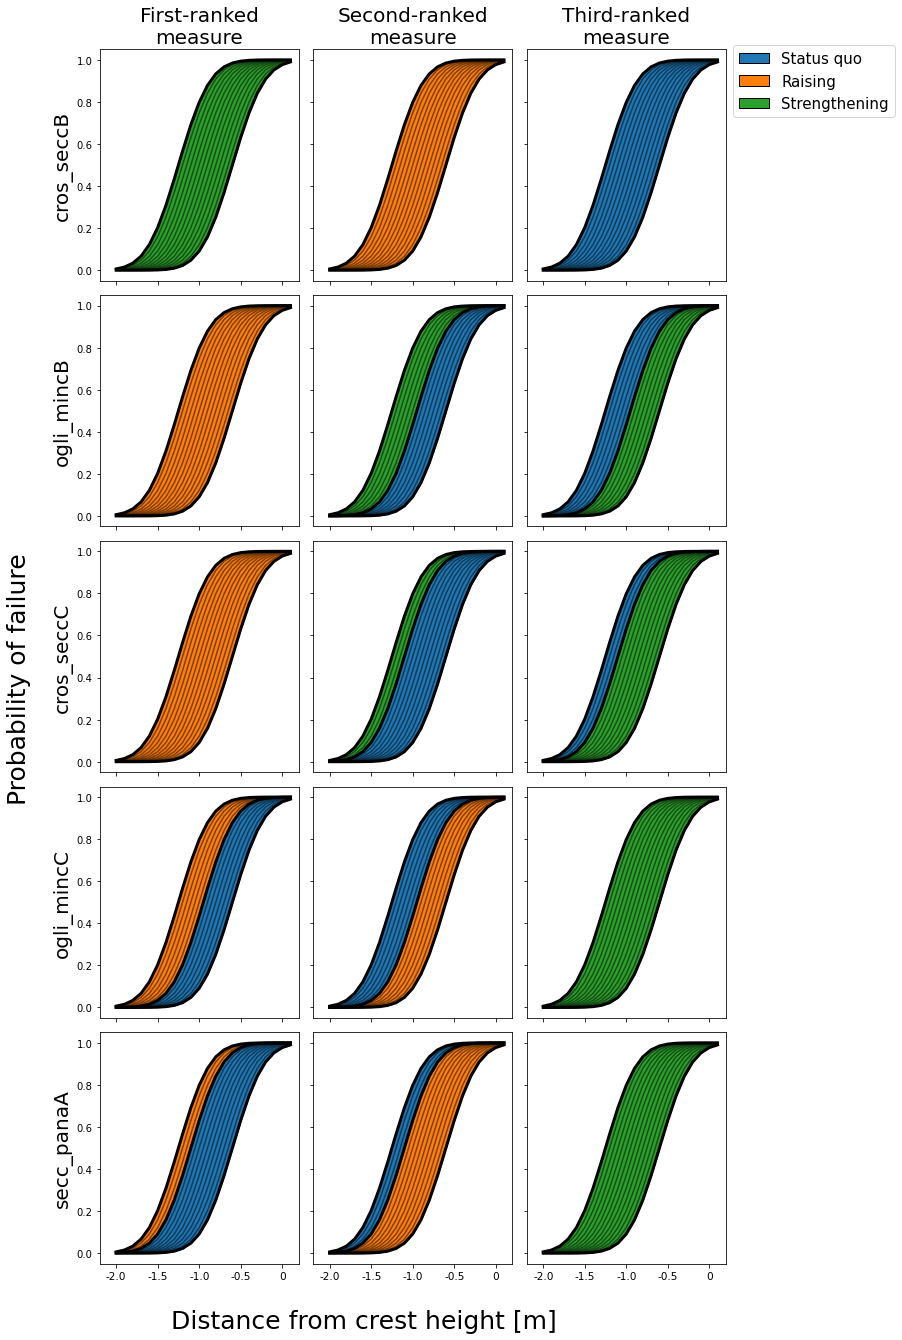

In [26]:
colors = plt.get_cmap("tab10").colors[:3]

titles = ['First-ranked\nmeasure', 'Second-ranked\nmeasure', 'Third-ranked\nmeasure']

p_nonexc = ['p_nonexc{}'.format(i) for i in range(1,15)]

pos = [[0,0], [0,1], [0,2], [1,0], [1,1], [1,2]]
lw = 3
fig, ax = plt.subplots(5,3, figsize=(12,18))
r = 0
for cmpt in cmpt_order:

    dummy_res = res[res.cmprt == cmpt][p_nonexc]
    ranking = dummy_res.rank(ascending=False).values
    
    for c in range(3):
        plot_distr(c, r, ranking, ax, distrs, x_height, xhs, lw)
        if r == 0:
            ax[r,c].set_title('{}'.format(titles[c]), size=20)
            
        if r == 4:
            ax[r,c].set_xticks(ax[r,c].get_xticks())
            ax[r,c].set_xticklabels(lables_, fontsize=10.5)
        else:
            ax[r,c].set_xticks(ax[r,c].get_xticks())
            ax[r,c].set_xticklabels([])
            
        if c == 0:
            ax[r,c].set_ylabel('{}'.format(cmpt), size=20)
        
        else:
            ax[r,c].set_yticklabels([])            
        
        ax[r,c].set_xlim((22.8, 25.2))

    r+=1

handles = [Patch(facecolor=c, edgecolor='k') for c in colors]

leg_labels = ['Status quo', 'Raising', 'Strengthening']
ax[0,2].legend(handles, leg_labels, bbox_to_anchor = (1.0,1.05), fontsize=15)
  
fig.text(-0.04, 0.38, 'Probability of failure', fontsize=25, rotation=90)
fig.text(0.15, -0.028, "Distance from crest height [m]", fontsize=25)

plt.tight_layout()